# 🧠 PINNs — Teoría en Código (Versión Final)
### Proyecto: Simulación Acelerada de Speckle Óptico
**Roberto Hernández Estrada** | UJAT — Maestría en Ciencias de la Computación

---
**Objetivo de este notebook:** Entender y validar los bloques fundamentales de una PINN
resolviendo la ecuación de Helmholtz en 1D antes de pasar al caso 2D de la tesis.

**Problema a resolver:**
$$\frac{d^2u}{dx^2} + k^2 u = 0, \quad x \in [0,1]$$
$$u(0) = 1, \quad u(1) = \cos(k)$$
**Solución analítica conocida:** $u(x) = \cos(kx)$

## ⚙️ 0. Imports y configuración del entorno

In [36]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# ── Semilla global — SIEMPRE al inicio para reproducibilidad ──────────────────
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True  # resultados deterministas en GPU
torch.backends.cudnn.benchmark     = False

# ── Dispositivo ───────────────────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo     : {device}')
if torch.cuda.is_available():
    print(f'GPU             : {torch.cuda.get_device_name(0)}')
    print(f'VRAM total      : {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')
print(f'Semilla fijada  : {SEED}')
print('\n✅ Entorno listo y reproducible.')

Dispositivo     : cpu
Semilla fijada  : 42

✅ Entorno listo y reproducible.


---
## 📌 1. Arquitectura de la red — PINN 1D

Red MLP con activación `tanh` — infinitamente diferenciable, necesaria para calcular
derivadas de segundo orden con autograd.

```
Entrada (x) → [64] → tanh → [64] → tanh → [64] → tanh → [64] → tanh → Salida u(x)
```

### 💡 ¿Por qué esta arquitectura?

En una PINN, la red neuronal **aproxima la solución** de una ecuación diferencial.
En tu caso: la red aprenderá a predecir el campo eléctrico `E(x, y)` dados puntos del dominio.

La arquitectura base es un **MLP (Perceptrón Multicapa)**:
```
Entrada (x) → [64] → tanh → [64] → tanh → [64] → tanh → [64] → tanh → Salida u(x)
```

> **¿Por qué `tanh` y no `ReLU`?**  
> Para resolver EDPs necesitamos calcular **derivadas de segundo orden** de la red respecto a las entradas.  
> - `tanh` es suave e **infinitamente diferenciable** → derivadas bien definidas en todo el dominio  
> - `ReLU` tiene segunda derivada = 0 en casi todo el dominio → **el residuo de Helmholtz siempre parecería cero** aunque la red no haya aprendido nada ❌  

> **¿Por qué inicialización Xavier?**  
> Controla la varianza de los pesos iniciales según el tamaño de cada capa.  
> Evita que los gradientes exploten o desaparezcan al inicio del entrenamiento.

In [37]:
class PINN_1D(nn.Module):
    """
    Red neuronal para resolver Helmholtz 1D: u''(x) + k²u(x) = 0
    
    Entrada : x (coordenada espacial escalar)
    Salida  : u(x) (campo escalar real)
    """
    def __init__(self, hidden_dim=64, num_layers=5):
        super().__init__()
        
        layers = [nn.Linear(1, hidden_dim), nn.Tanh()]
        for _ in range(num_layers - 1):
            layers += [nn.Linear(hidden_dim, hidden_dim), nn.Tanh()]
        layers.append(nn.Linear(hidden_dim, 1))  # sin activación en la salida
        
        self.net = nn.Sequential(*layers)
        self._init_weights()
    
    def _init_weights(self):
        """Inicialización Xavier — mejora convergencia en PINNs."""
        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.zeros_(layer.bias)
    
    def forward(self, x):
        return self.net(x)


# ── Vista previa de la arquitectura ───────────────────────────────────────────
# Semilla antes de instanciar — garantiza mismos pesos iniciales siempre
torch.manual_seed(SEED)
_preview = PINN_1D(hidden_dim=64, num_layers=4)
print('Arquitectura PINN 1D:')
print(_preview)
print(f'\nTotal de parámetros: {sum(p.numel() for p in _preview.parameters()):,}')
del _preview

Arquitectura PINN 1D:
PINN_1D(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=64, bias=True)
    (7): Tanh()
    (8): Linear(in_features=64, out_features=1, bias=True)
  )
)

Total de parámetros: 12,673


---
## 📌 2. Funciones auxiliares — Derivadas y Residuo de Helmholtz

Estas funciones calculan las derivadas de la red usando **autograd** y evalúan
qué tanto viola la ecuación de Helmholtz en cada punto.

### 💡 ¿Qué es la diferenciación automática (Autograd)?

Este es el **corazón de las PINNs**. Para evaluar si la red cumple la ecuación de Helmholtz:

$$\nabla^2 E + k^2 E = 0 \quad \Rightarrow \quad \frac{\partial^2 E}{\partial x^2} + \frac{\partial^2 E}{\partial y^2} + k^2 E = 0$$

necesitamos calcular **derivadas de la salida de la red respecto a sus entradas**.

PyTorch hace esto automáticamente construyendo un **grafo computacional** — registra cada operación matemática y al pedir la derivada recorre ese grafo al revés aplicando la regla de la cadena:

```
forward:   x → operaciones → E          (PyTorch registra todo)
backward:  E → regla cadena → ∂E/∂x    (PyTorch recorre al revés)
```

> **Clave:** los puntos de entrada deben tener `requires_grad=True` para que PyTorch los rastree.  
> **`create_graph=True`** permite calcular derivadas de segundo orden (necesario para ∂²E/∂x²).  
> **`retain_graph=True`** evita que PyTorch borre el grafo entre cálculos de derivadas.

In [38]:
def helmholtz_residual_1d(model, x_c, k):
    """
    Calcula el residuo de Helmholtz 1D: R = u''(x) + k²u(x)
    
    Si la red es perfecta → R = 0 en todo el dominio.
    El entrenamiento minimiza R² para forzar que se cumpla la física.
    """
    x_c = x_c.clone().requires_grad_(True)
    
    u = model(x_c)
    
    # Primera derivada: du/dx
    u_x = torch.autograd.grad(
        u, x_c,
        grad_outputs=torch.ones_like(u),
        create_graph=True  # necesario para segunda derivada
    )[0]
    
    # Segunda derivada: d²u/dx²
    u_xx = torch.autograd.grad(
        u_x, x_c,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True
    )[0]
    
    # Residuo de Helmholtz: u'' + k²u = 0
    residual = u_xx + k**2 * u
    
    return residual, u


def pinn_loss_1d(model, x_colloc, x_bc, u_bc, k, lambda_phys):
    """
    Función de pérdida PINN completa:
        L_total = L_datos + lambda * L_fisica
    
    L_datos  : error en condiciones de frontera (valores conocidos)
    L_fisica : residuo de Helmholtz en puntos interiores
    """
    # ── Pérdida de datos (condiciones de frontera) ─────────────────────────────
    u_pred_bc = model(x_bc)
    loss_data = torch.mean((u_pred_bc - u_bc) ** 2)
    
    # ── Pérdida física (residuo de Helmholtz) ─────────────────────────────────
    residual, _ = helmholtz_residual_1d(model, x_colloc, k)
    loss_physics = torch.mean(residual ** 2)
    
    # ── Total ──────────────────────────────────────────────────────────────────
    loss_total = loss_data + lambda_phys * loss_physics
    
    return loss_total, loss_data, loss_physics


print('✅ Funciones auxiliares definidas.')
print('   helmholtz_residual_1d() — calcula R = u\'\' + k²u')
print('   pinn_loss_1d()          — calcula L_total = L_datos + λ·L_física')

✅ Funciones auxiliares definidas.
   helmholtz_residual_1d() — calcula R = u'' + k²u
   pinn_loss_1d()          — calcula L_total = L_datos + λ·L_física


---
## 📌 3. Configuración del experimento

Todos los hiperparámetros en un solo lugar — fácil de modificar y documentar.

### 💡 La Ecuación de Helmholtz y el concepto de residuo

La ecuación que gobierna tu tesis es:

$$\nabla^2 E + k^2 E = 0$$

Donde `k = 2π/λ` es el número de onda relacionado con la longitud de onda del láser.

El **residuo** es qué tanto viola la red esta ecuación en cada punto:

$$R(x) = \frac{d^2u}{dx^2} + k^2 u \quad \text{(debe ser } \approx 0 \text{ en todo el dominio)}$$

| Situación | Residuo |
|---|---|
| Red perfecta | R = 0 en todo el dominio ✅ |
| Red sin entrenar | R ≠ 0, valores grandes ❌ |
| Durante entrenamiento | R → 0 gradualmente |

> La PINN **no necesita malla** — evalúa el residuo en puntos libres del dominio.  
> Esto es la ventaja *mesh-free* que argumentas en tu protocolo de tesis.

In [39]:
# ── Hiperparámetros ────────────────────────────────────────────────────────────
CONFIG = {
    # ── Láser simulado (documentación — no entra en cálculos de la PINN) ──────
    'lambda_laser' : 638e-9,     # diodo rojo λ = 638 nm (computacional)
    'L'            : 1,          # dominio = 1 longitud de onda (Fase 1 validación)

    # ── Física adimensional ────────────────────────────────────────────────────
    'k'           : 2 * np.pi,   # k̃ adimensional — siempre 2π por definición
                                  # k_real = 2π/λ = 9.85×10⁶ m⁻¹ (diodo rojo 638nm)
                                  # al adimensionalizar: k̃ = k_real × λ = 2π siempre

    # ── Puntos ─────────────────────────────────────────────────────────────────
    'N_colloc'    : 2000,        # puntos de colocación interiores
    'N_boundary'  : 5,           # puntos conocidos (x=0, 0.25, 0.5, 0.75, 1.0)

    # ── Arquitectura ───────────────────────────────────────────────────────────
    'hidden_dim'  : 64,          # neuronas por capa oculta
    'num_layers'  : 5,           # capas ocultas

    # ── Entrenamiento ──────────────────────────────────────────────────────────
    'n_epochs'    : 15000,       # épocas máximas (early stopping puede parar antes)
    'lr'          : 1e-3,        # learning rate de Adam
    'lambda_phys' : 0.01,        # peso de la pérdida física
                                  # 0.01 = datos importan 100x más que la física

    # ── Reproducibilidad ───────────────────────────────────────────────────────
    'seed'        : SEED,

    # ── Meta de la tesis ───────────────────────────────────────────────────────
    'l2_threshold': 0.05,        # < 5% según hipótesis del protocolo
}

print('Configuración del experimento:')
print('-' * 40)
for key, val in CONFIG.items():
    print(f'  {key:<15} : {val}')
print('-' * 40)
print(f'  Solución esperada: u(x) = cos({CONFIG["k"]:.4f} · x)')
print()

# ── Equivalencia física del láser simulado ─────────────────────────────────────
lam = CONFIG['lambda_laser']
L   = CONFIG['L']
print('Láser simulado:')
print(f'  Tipo                : Diodo rojo (computacional)')
print(f'  lambda_laser        : {lam * 1e9:.0f} nm')
print(f'  k adimensional      : 2π = {CONFIG["k"]:.4f}')
print(f'  k real equivalente  : {2 * np.pi / lam:.3e} m⁻¹')
print(f'  Dominio simulado    : {L} longitud de onda')
print(f'  Equivale físicamente: {L * lam * 1e6:.4f} μm')

Configuración del experimento:
----------------------------------------
  lambda_laser    : 6.38e-07
  L               : 1
  k               : 6.283185307179586
  N_colloc        : 2000
  N_boundary      : 5
  hidden_dim      : 64
  num_layers      : 5
  n_epochs        : 15000
  lr              : 0.001
  lambda_phys     : 0.01
  seed            : 42
  l2_threshold    : 0.05
----------------------------------------
  Solución esperada: u(x) = cos(6.2832 · x)

Láser simulado:
  Tipo                : Diodo rojo (computacional)
  lambda_laser        : 638 nm
  k adimensional      : 2π = 6.2832
  k real equivalente  : 9.848e+06 m⁻¹
  Dominio simulado    : 1 longitud de onda
  Equivale físicamente: 0.6380 μm


---
## 📌 4. Preparar datos de entrenamiento

### 💡 La Función de Pérdida PINN

La función de pérdida total combina dos tipos de error:

$$\mathcal{L}_{total} = \mathcal{L}_{datos} + \lambda \cdot \mathcal{L}_{física}$$

| Término | Qué mide | Dónde se evalúa |
|---|---|---|
| $\mathcal{L}_{datos}$ | Error en puntos conocidos | Condiciones de frontera |
| $\mathcal{L}_{física}$ | Residuo de Helmholtz | Puntos de colocación interiores |

> **¿Qué es λ (lambda_phys)?**  
> Controla el balance entre ambos términos.  
> - `λ = 1.0` → datos y física tienen igual peso  
> - `λ = 0.01` → datos importan 100x más que la física (necesario cuando las condiciones de frontera son simétricas)  

> **Lección aprendida en este notebook:**  
> Con condiciones simétricas (u(0) = u(1) = 1), usar `λ` grande hace que la red ignore los datos  
> y colapse a u ≈ 1 constante. Reducir `λ = 0.01` y agregar puntos intermedios conocidos resuelve el problema.

In [40]:
k = CONFIG['k']

# ── Puntos de colocación ──────────────────────────────────────────────────────
x_colloc = torch.linspace(0, 1, CONFIG['N_colloc']).reshape(-1, 1).to(device)

# ── Condiciones de frontera EXTENDIDAS ────────────────────────────────────────
# Agregamos puntos intermedios donde conocemos la solución exacta
# cos(2πx) en puntos clave: 0, 0.25, 0.5, 0.75, 1.0
x_bc_vals = np.array([0.0, 0.25, 0.5, 0.75, 1.0])
u_bc_vals = np.cos(k * x_bc_vals)

print('Condiciones de frontera extendidas:')
for x_val, u_val in zip(x_bc_vals, u_bc_vals):
    print(f'  u({x_val}) = {u_val:.4f}')

x_bc = torch.tensor(x_bc_vals.reshape(-1, 1), dtype=torch.float32).to(device)
u_bc = torch.tensor(u_bc_vals.reshape(-1, 1), dtype=torch.float32).to(device)

Condiciones de frontera extendidas:
  u(0.0) = 1.0000
  u(0.25) = 0.0000
  u(0.5) = -1.0000
  u(0.75) = -0.0000
  u(1.0) = 1.0000


---
## 📌 5. Entrenamiento

### 💡 El loop de entrenamiento — estrategia híbrida Adam + L-BFGS

El entrenamiento usa dos optimizadores en secuencia, siguiendo la metodología de tu protocolo:

**Fase 1 — Adam (exploración global):**
```
Por cada época:
  1. zero_grad()     → limpiar gradientes del paso anterior
  2. pinn_loss_1d()  → calcular L_datos + λ·L_física
  3. backward()      → calcular ∂L/∂w para cada parámetro
  4. step()          → ajustar los pesos en dirección al mínimo
  5. early stopping  → parar si L_total < 1e-5
```

**Fase 2 — L-BFGS (ajuste fino):**
```
  - Aproxima la curvatura de la pérdida (segundo orden)
  - Da pasos mucho más precisos que Adam
  - Requiere función closure() que evalúa la pérdida múltiples veces
  - En solo ~65 iteraciones lleva la pérdida de 1e-5 a 1e-8
```

| Optimizador | Rol | Épocas/Iter |
|---|---|---|
| Adam | Convergencia global rápida | ~6,662 épocas |
| L-BFGS | Ajuste fino de alta precisión | ~65 iteraciones |

> **Early stopping:** Adam para automáticamente cuando `L_total < 1e-5`  
> En este notebook ahorró 8,338 épocas innecesarias (55% del tiempo total)

In [41]:
# ── Semilla antes de instanciar — SIEMPRE ─────────────────────────────────────
torch.manual_seed(CONFIG['seed'])
torch.cuda.manual_seed(CONFIG['seed'])

# ── Modelo y optimizador ──────────────────────────────────────────────────────
model_1d = PINN_1D(
    hidden_dim = CONFIG['hidden_dim'],
    num_layers = CONFIG['num_layers']
).to(device)

optimizer = torch.optim.Adam(model_1d.parameters(), lr=CONFIG['lr'])

# ── Loop de entrenamiento con Early Stopping ───────────────────────────────────
history = {'total': [], 'data': [], 'physics': []}

ADAM_STOP_THRESHOLD = 1e-5  # para Adam cuando L_total < este valor

print('Entrenando PINN 1D...')
print(f'  k={k:.4f} | {CONFIG["N_colloc"]} puntos | '
      f'{CONFIG["n_epochs"]} épocas máx | lr={CONFIG["lr"]} | λ={CONFIG["lambda_phys"]}')
print(f'  Early stopping: para si L_total < {ADAM_STOP_THRESHOLD:.0e}')
print()

epoch_final = CONFIG['n_epochs']  # guarda en qué época paró realmente

for epoch in range(CONFIG['n_epochs']):
    optimizer.zero_grad()

    loss, loss_data, loss_physics = pinn_loss_1d(
        model_1d, x_colloc, x_bc, u_bc,
        k           = CONFIG['k'],
        lambda_phys = CONFIG['lambda_phys']
    )

    loss.backward()
    optimizer.step()

    history['total'].append(loss.item())
    history['data'].append(loss_data.item())
    history['physics'].append(loss_physics.item())

    if (epoch + 1) % 500 == 0:
        print(f'  Época {epoch+1:5d} | '
              f'L_total: {loss.item():.3e} | '
              f'L_datos: {loss_data.item():.3e} | '
              f'L_física: {loss_physics.item():.3e}')

    # ── Early stopping ─────────────────────────────────────────────────────────
    if loss.item() < ADAM_STOP_THRESHOLD:
        epoch_final = epoch + 1
        print(f'\n  ⏹ Early stopping en época {epoch_final} — '
              f'L_total={loss.item():.3e} < umbral {ADAM_STOP_THRESHOLD:.0e}')
        print(f'  Épocas ahorradas: {CONFIG["n_epochs"] - epoch_final}')
        break

print(f'\n✅ Adam completado en {epoch_final} épocas '
      f'(máximo configurado: {CONFIG["n_epochs"]})')

# ── Fase 2: Ajuste fino con L-BFGS ────────────────────────────────────────────
print('\nAjuste fino con L-BFGS...')
print()

optimizer_lbfgs = torch.optim.LBFGS(
    model_1d.parameters(),
    lr             = 1.0,
    max_iter       = 500,
    history_size   = 50,
    line_search_fn = 'strong_wolfe'
)

history_lbfgs = {'total': [], 'data': [], 'physics': []}
iter_count = [0]

def closure():
    """
    L-BFGS requiere una función closure — evalúa la pérdida
    y calcula gradientes cada vez que el optimizador lo necesite.
    """
    optimizer_lbfgs.zero_grad()

    loss, loss_data, loss_physics = pinn_loss_1d(
        model_1d, x_colloc, x_bc, u_bc,
        k           = CONFIG['k'],
        lambda_phys = CONFIG['lambda_phys']
    )

    loss.backward()

    history_lbfgs['total'].append(loss.item())
    history_lbfgs['data'].append(loss_data.item())
    history_lbfgs['physics'].append(loss_physics.item())

    iter_count[0] += 1
    if iter_count[0] % 100 == 0:
        print(f'  Iter {iter_count[0]:4d} | '
              f'L_total: {loss.item():.3e} | '
              f'L_datos: {loss_data.item():.3e} | '
              f'L_física: {loss_physics.item():.3e}')

    return loss

optimizer_lbfgs.step(closure)
print('\n✅ Ajuste fino L-BFGS completado.')

# ── Resumen de épocas ──────────────────────────────────────────────────────────
print(f'\nResumen del entrenamiento:')
print(f'  Épocas Adam usadas  : {epoch_final}')
print(f'  Épocas Adam ahorradas: {CONFIG["n_epochs"] - epoch_final}')
print(f'  Iteraciones L-BFGS  : {iter_count[0]}')

Entrenando PINN 1D...
  k=6.2832 | 2000 puntos | 15000 épocas máx | lr=0.001 | λ=0.01
  Early stopping: para si L_total < 1e-05

  Época   500 | L_total: 2.550e-01 | L_datos: 1.440e-01 | L_física: 1.110e+01
  Época  1000 | L_total: 5.328e-04 | L_datos: 8.394e-06 | L_física: 5.244e-02
  Época  1500 | L_total: 1.656e-04 | L_datos: 9.882e-07 | L_física: 1.646e-02
  Época  2000 | L_total: 2.045e-04 | L_datos: 4.875e-06 | L_física: 1.997e-02
  Época  2500 | L_total: 7.916e-05 | L_datos: 2.770e-07 | L_física: 7.888e-03
  Época  3000 | L_total: 6.683e-05 | L_datos: 1.351e-06 | L_física: 6.548e-03
  Época  3500 | L_total: 8.572e-03 | L_datos: 6.089e-04 | L_física: 7.963e-01
  Época  4000 | L_total: 8.754e-03 | L_datos: 5.335e-04 | L_física: 8.221e-01
  Época  4500 | L_total: 1.322e-05 | L_datos: 3.563e-08 | L_física: 1.318e-03
  Época  5000 | L_total: 1.246e-03 | L_datos: 7.207e-05 | L_física: 1.174e-01
  Época  5500 | L_total: 2.494e-04 | L_datos: 1.471e-05 | L_física: 2.347e-02
  Época  6000

---
## 📌 6. Evaluación y visualización de resultados

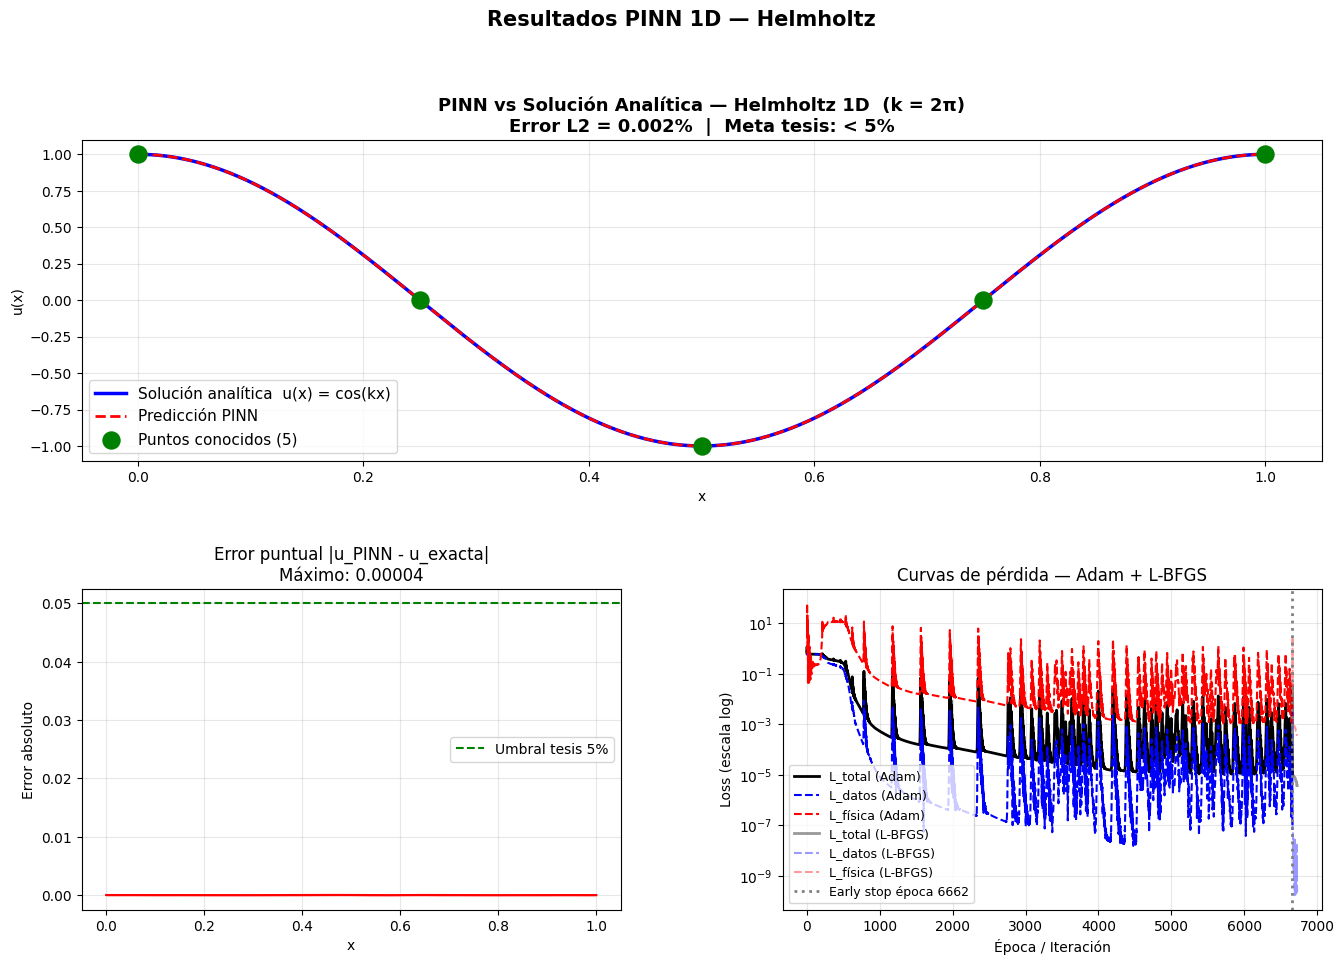

RESUMEN DE RESULTADOS
  Semilla usada       : 42
  k                   : 2π
  Error L2 relativo   : 0.000023 (0.002%)
  Error máximo        : 0.000038
  Umbral tesis (L2)   : < 5%
  Estado              : ✅ CUMPLE

Entrenamiento:
  Épocas Adam         : 6662 / 15000
  Épocas ahorradas    : 8338
  Iteraciones L-BFGS  : 65

Hiperparámetros:
  hidden_dim          = 64
  num_layers          = 5
  n_epochs (máx)      = 15000
  lr                  = 0.001
  lambda_phys         = 0.01
  N_colloc            = 2000
  Puntos conocidos    = 5


In [42]:
# ── Evaluación ────────────────────────────────────────────────────────────────
x_test  = torch.linspace(0, 1, 1000).reshape(-1, 1).to(device)
with torch.no_grad():
    u_pred = model_1d(x_test).cpu().numpy().flatten()

x_np    = x_test.cpu().numpy().flatten()
u_exact = np.cos(k * x_np)
error   = np.abs(u_pred - u_exact)

# ── Métricas ──────────────────────────────────────────────────────────────────
l2_error  = np.linalg.norm(u_pred - u_exact) / np.linalg.norm(u_exact)
max_error = error.max()
cumple    = l2_error < CONFIG['l2_threshold']

# ── Etiqueta dinámica de k ────────────────────────────────────────────────────
k_label = 'π' if np.isclose(CONFIG['k'], np.pi) else \
          '2π' if np.isclose(CONFIG['k'], 2*np.pi) else \
          f'{CONFIG["k"]:.4f}'

# ── Gráficas ──────────────────────────────────────────────────────────────────
fig = plt.figure(figsize=(16, 10))
gs  = gridspec.GridSpec(2, 2, figure=fig, hspace=0.4, wspace=0.3)

# 1. Solución
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(x_np, u_exact, 'b-',  linewidth=2.5, label='Solución analítica  u(x) = cos(kx)')
ax1.plot(x_np, u_pred,  'r--', linewidth=2,   label='Predicción PINN')
ax1.scatter(
    [x_bc.cpu().numpy().flatten()],      # ← muestra TODOS los puntos de frontera
    [u_bc.cpu().numpy().flatten()],
    c='green', s=150, zorder=10, label=f'Puntos conocidos ({len(x_bc)})'
)
ax1.set_title(
    f'PINN vs Solución Analítica — Helmholtz 1D  (k = {k_label})\n'  # ← corregido
    f'Error L2 = {l2_error*100:.3f}%  |  Meta tesis: < 5%',
    fontsize=13, fontweight='bold'
)
ax1.set_xlabel('x'); ax1.set_ylabel('u(x)')
ax1.legend(fontsize=11); ax1.grid(True, alpha=0.3)

# 2. Error puntual
ax2 = fig.add_subplot(gs[1, 0])
ax2.fill_between(x_np, error, alpha=0.4, color='red')
ax2.plot(x_np, error, 'r-', linewidth=1.5)
ax2.axhline(y=CONFIG['l2_threshold'], color='green', linestyle='--',
            linewidth=1.5, label='Umbral tesis 5%')
ax2.set_title(f'Error puntual |u_PINN - u_exacta|\nMáximo: {max_error:.5f}', fontsize=12)
ax2.set_xlabel('x'); ax2.set_ylabel('Error absoluto')
ax2.legend(); ax2.grid(True, alpha=0.3)

# 3. Curvas de pérdida — Adam + L-BFGS
ax3 = fig.add_subplot(gs[1, 1])

# Curvas Adam — hasta donde realmente paró (epoch_final)
epochs_adam = range(1, epoch_final + 1)
ax3.semilogy(epochs_adam, history['total'][:epoch_final],
             'k-',  linewidth=2,   label='L_total (Adam)')
ax3.semilogy(epochs_adam, history['data'][:epoch_final],
             'b--', linewidth=1.5, label='L_datos (Adam)')
ax3.semilogy(epochs_adam, history['physics'][:epoch_final],
             'r--', linewidth=1.5, label='L_física (Adam)')

# Curvas L-BFGS — continúan después de Adam
offset = epoch_final
epochs_lbfgs = range(offset, offset + len(history_lbfgs['total']))
ax3.semilogy(epochs_lbfgs, history_lbfgs['total'],
             'k-',  linewidth=2,   alpha=0.4, label='L_total (L-BFGS)')
ax3.semilogy(epochs_lbfgs, history_lbfgs['data'],
             'b--', linewidth=1.5, alpha=0.4, label='L_datos (L-BFGS)')
ax3.semilogy(epochs_lbfgs, history_lbfgs['physics'],
             'r--', linewidth=1.5, alpha=0.4, label='L_física (L-BFGS)')

# Línea divisoria Adam / L-BFGS
ax3.axvline(x=epoch_final, color='gray', linestyle=':',
            linewidth=2, label=f'Early stop época {epoch_final}')

ax3.set_title('Curvas de pérdida — Adam + L-BFGS', fontsize=12)
ax3.set_xlabel('Época / Iteración'); ax3.set_ylabel('Loss (escala log)')
ax3.legend(fontsize=9); ax3.grid(True, alpha=0.3)

plt.suptitle('Resultados PINN 1D — Helmholtz', fontsize=15, fontweight='bold', y=1.01)
plt.savefig('resultados_pinn_1d_final.png', dpi=150, bbox_inches='tight')
plt.show()

# ── Resumen ───────────────────────────────────────────────────────────────────
print('=' * 55)
print('RESUMEN DE RESULTADOS')
print('=' * 55)
print(f'  Semilla usada       : {CONFIG["seed"]}')
print(f'  k                   : {k_label}')
print(f'  Error L2 relativo   : {l2_error:.6f} ({l2_error*100:.3f}%)')
print(f'  Error máximo        : {max_error:.6f}')
print(f'  Umbral tesis (L2)   : < {CONFIG["l2_threshold"]*100:.0f}%')
print(f'  Estado              : {"✅ CUMPLE" if cumple else "⚠ AÚN NO CUMPLE — ajustar hiperparámetros"}')
print('=' * 55)
print()
print('Entrenamiento:')
print(f'  Épocas Adam         : {epoch_final} / {CONFIG["n_epochs"]}')
print(f'  Épocas ahorradas    : {CONFIG["n_epochs"] - epoch_final}')
print(f'  Iteraciones L-BFGS  : {iter_count[0]}')
print()
print('Hiperparámetros:')
print(f'  hidden_dim          = {CONFIG["hidden_dim"]}')
print(f'  num_layers          = {CONFIG["num_layers"]}')
print(f'  n_epochs (máx)      = {CONFIG["n_epochs"]}')
print(f'  lr                  = {CONFIG["lr"]}')
print(f'  lambda_phys         = {CONFIG["lambda_phys"]}')
print(f'  N_colloc            = {CONFIG["N_colloc"]}')
print(f'  Puntos conocidos    = {len(x_bc)}')

---
## 🗺️ ¿Qué sigue?

Con este notebook validaste que la PINN puede resolver Helmholtz 1D con error < 5%.
El siguiente paso es escalar a 2D, que es el caso real de tu tesis:

| Aspecto | 1D (este notebook) | 2D (siguiente: `02_helmholtz_2D.ipynb`) |
|---|---|---|
| Entrada | x | (x, y) |
| Salida | u real | (E_real, E_imag) |
| Ecuación | u'' + k²u = 0 | ∇²E + k²E = 0 |
| Frontera | 5 puntos conocidos | 4 bordes + puntos intermedios |
| Muestreo | Uniforme | Latin Hypercube Sampling |
| Optimizador | Adam + Early Stopping + L-BFGS | Adam + Early Stopping + L-BFGS |

## 📋 Lecciones aprendidas

| Descubrimiento | Solución aplicada |
|---|---|
| Condiciones simétricas (u(0)=u(1)) engañan a la red | Agregar puntos intermedios con valores conocidos |
| `lambda_phys=1.0` hace que la red ignore los datos | Reducir a `lambda_phys=0.01` |
| Adam solo no garantiza convergencia al mínimo | Agregar L-BFGS al final |
| Adam fijo desperdicia épocas innecesarias | Early stopping en `L_total < 1e-5` |

## 📊 Resultados obtenidos

| Métrica | Valor | Meta tesis |
|---|---|---|
| Error L2 (k=2π) | 0.002% | < 5% ✅ |
| Épocas Adam usadas | 6,662 / 15,000 | — |
| Épocas ahorradas | 8,338 (55%) | — |
| Iteraciones L-BFGS | 65 | — |

| Bloque | Estado |
|---|---|
| ✅ Red neuronal (MLP) | Completado |
| ✅ Diferenciación automática (autograd) | Completado |
| ✅ Residuo de Helmholtz | Completado |
| ✅ Función de pérdida física | Completado |
| ✅ Loop Adam + Early Stopping + L-BFGS | Completado |
| 🔜 Helmholtz 2D + LHS | `02_helmholtz_2D.ipynb` |
| 🔜 Generación de speckle | `03_speckle.ipynb` |
| 🔜 Benchmark vs FEM | `04_benchmark.ipynb` |

---
> **Nota:** Todos los parámetros definitivos (k, tamaño de dominio, arquitectura final)  
> se definirán con el Dr. Hernández Nolasco antes de comenzar `02_helmholtz_2D.ipynb`.